In [3]:
%cd ..

/Users/vanguyen/influence-release


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)

from load_animals import load_animals
from influence.image_utils import plot_flat_colorimage, plot_flat_colorgrad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
num_classes = 2
num_train_ex_per_class = 900
num_test_ex_per_class = 300

model_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
image_data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
    classes=['dog', 'fish'])

Loading animals from disk...


In [6]:
X_train = image_data_sets.train.x
X_test = image_data_sets.test.x
Y_train = image_data_sets.train.labels * 2 - 1
Y_test = image_data_sets.test.labels * 2 - 1

In [8]:
import pickle

f, correlation_list, margin_list = pickle.load(open('output/rbf_results.p', 'rb'))

test_idxs = f['test_idxs']
distances = f['distances']
flipped_idxs = f['flipped_idxs']
rbf_margins_test = f['rbf_margins_test']
rbf_margins_train = f['rbf_margins_train']
print(test_idxs)
print(min(rbf_margins_train))
print(min(rbf_margins_test))
influences = f['influences']
print(len(influences))
hinge_W = f['hinge_W']

range(0, 600)
-1.5927862
-1.2390565
600


Sum abs influences 4.459058625811915
1033
SV influence % 0.8014628234145101


Text(0,0.5,'Absolute influence')

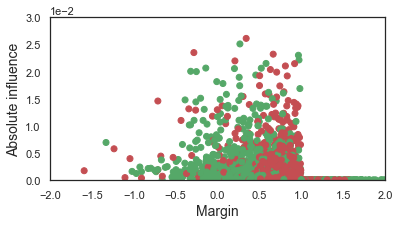

In [109]:
abs_influences = [abs(inf) for inf in rbf_predicted_loss_diffs]
abs_margins = [margin for margin in rbf_margins_train]
print("Sum abs influences", sum(abs_influences))
support_vectors = [idx for idx in range(len(Y_train)) if -0.8 < rbf_margins_train[idx] < 0.8]
sv_abs_influences = [abs_influences[idx] for idx in support_vectors]
print(len(support_vectors))
print("SV influence %", sum(sv_abs_influences)/sum(abs_influences))


sns.set_style('white')
fontsize=10
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6, 3))
axs.scatter(abs_margins, abs_influences, color=color_vec)
axs.set_xlim([-2, 2])
axs.set_ylim([0., 0.03])
axs.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs.set_xlabel('Margin', fontsize=fontsize)
axs.set_ylabel('Absolute influence', fontsize=fontsize)

Text(0,0.5,'Weight-Influence Correlation')

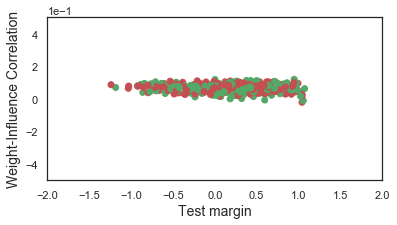

In [121]:
test_margins = [rbf_margins_test[i] for i in range(len(X_test))]
corr = []
for i in range(len(X_test)):
    influence = influences[i]
    abs_influence = [abs(inf) for inf in influence]
    abs_weights = [abs(w) for w in hinge_W]
    corr.append(np.corrcoef(abs_influence, abs_weights)[0, 1])

sns.set_style('white')
fontsize=14
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6, 3))
axs.scatter(test_margins, corr, color=color_vec)
axs.set_xlim([-2, 2])
axs.set_ylim([-0.5, 0.5])
axs.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs.set_xlabel('Test margin', fontsize=fontsize)
axs.set_ylabel('Weight-Influence Correlation', fontsize=fontsize)

0.7393244610682068


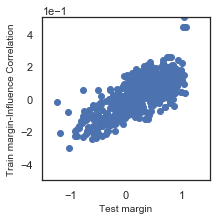

In [21]:
test_margins = [rbf_margins_test[i] for i in range(len(X_test))]
correct_test_margins = []
corr = []
for i in range(len(X_test)):
    influence = influences[i]
    influence_idx = [i for i, inf in enumerate(influence) if inf != 0]
    if len(influence_idx) == 0:
        continue
    correct_influence = [inf for i, inf in enumerate(influence) if inf != 0]
    train_margins = [margin for i, margin in enumerate(rbf_margins_train) if i in influence_idx]
    corr.append(np.corrcoef(correct_influence, train_margins)[0, 1])
    correct_test_margins.append(rbf_margins_test[i])
print(np.corrcoef(correct_test_margins, corr)[0, 1])
sns.set_style('white')
fontsize=14
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.scatter(correct_test_margins, corr)
axs.set_xlim([-1.5, 1.5])
axs.set_ylim([-0.5, 0.5])
axs.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs.set_xlabel('Test margin', fontsize=10)
axs.set_ylabel('Train margin-Influence Correlation', fontsize=10)
plt.savefig("figs/margin-influence-corr.png", dpi=300, bbox_inches='tight')

[237, 162, 462, 117, 287, 67, 400, 558, 187, 93]
Test idx 238
Margin 0.04097742 Offset 0.959022581577301
True label 1.0


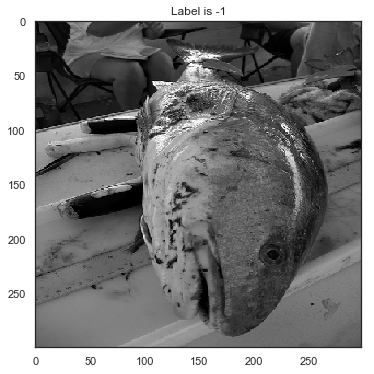

In [106]:
margins = {}
import operator
for i, test_sample in enumerate(X_test):
    margins[i] = abs(1. - rbf_margins_test[i])
sorted_margins = sorted(margins.items(), key=operator.itemgetter(1))
print([x[0] for x in sorted_margins[:10]])
test_idx = sorted_margins[400][0]
# print(test_idx)

distance = distances[test_idx]
flipped_idx = flipped_idxs[test_idx]
rbf_predicted_loss_diffs = influences[test_idx]

print("Test idx", test_idx)
print("Margin", rbf_margins_test[test_idx], "Offset", margins[test_idx])
print("True label", Y_test[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)

[-5.16822173e-04 -2.29192774e-04  1.04746787e-02 ...  5.44902103e-05
 -9.72113291e-03  1.25366939e-03]
Margin 0.99999994 Offset 1.9999999403953552
174
True label -1.0
Weight -1.0030383
Influence -1.0030383


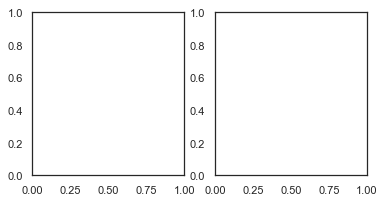

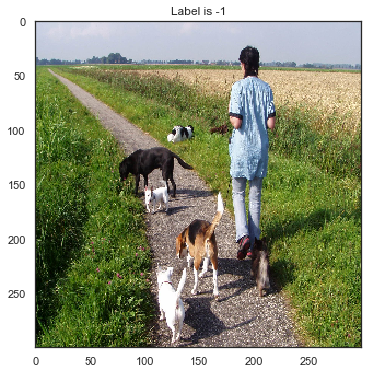

-0.031786546971112585
600 600


<Figure size 432x288 with 0 Axes>

In [31]:
sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

print(rbf_predicted_loss_diffs)
abs_weights = [abs(w) for w in hinge_W]
abs_influences = [abs(inf) for inf in rbf_predicted_loss_diffs]
abs_dist_to_margin = [abs(rbf_margins_train[idx]-Y_train[idx]) for idx in range(len(Y_train))]

neg_pts = [(idx, abs(rbf_margins_train[idx]-Y_train[idx])) for idx in range(len(Y_train)) if Y_train[idx] == -1]
train_idx = neg_pts[1][0]
print("Margin", rbf_margins_train[train_idx], "Offset", abs(rbf_margins_train[train_idx]-Y_train[train_idx]))

sv = [idx for idx in range(len(Y_train)) if abs(rbf_margins_train[idx]) == 1]
print(len(sv))

print("True label", Y_train[train_idx])
print("Weight", hinge_W[train_idx])
print("Influence", hinge_W[train_idx])
plot_flat_colorimage((X_train[train_idx, :] + 1) / 2, 0, side=299)

print(np.corrcoef(abs_dist_to_margin, abs_influences)[0, 1])


print(len(margin_list), len(correlation_list))
axs[0].scatter(margin_list, correlation_list, color=color_vec)
axs[0].set_xlim([0, 800])
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Margin', fontsize=fontsize)
axs[0].set_ylabel('Correlation', fontsize=fontsize)

axs[1].scatter(abs_dist_to_margin, abs_influences, color=color_vec)
axs[1].set_xlim([0, 2])
axs[1].set_ylim(0, 0.03)
# axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Weights', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

plt.tight_layout()

Test image:
1.0 0.9900306


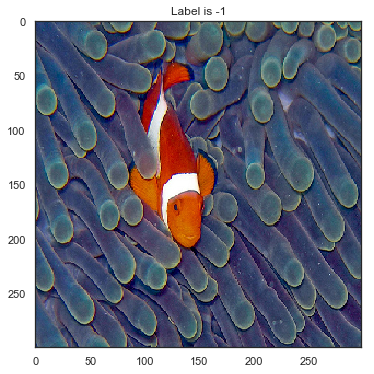

Top from RBF:
1103 1.0 194.05157 0.28052008 0.018163585662841798
1700 1.0 231.3802 0.2058113 0.01833178202311198
286 1.0 206.63591 0.6800407 0.020472967359754773
765 1.0 214.33142 -0.3200709 0.02152228461371528
925 1.0 254.57011 0.44896275 0.0223647583855523


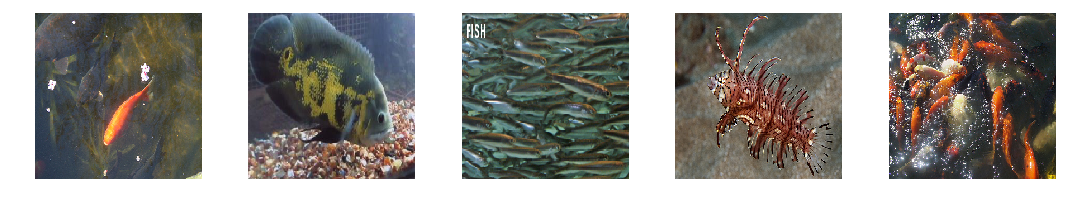

Dogs:
81 1066 -1.0 277.50177
97 1231 -1.0 288.83505
101 1709 -1.0 320.92932
115 492 -1.0 269.00986
119 83 -1.0 277.22968


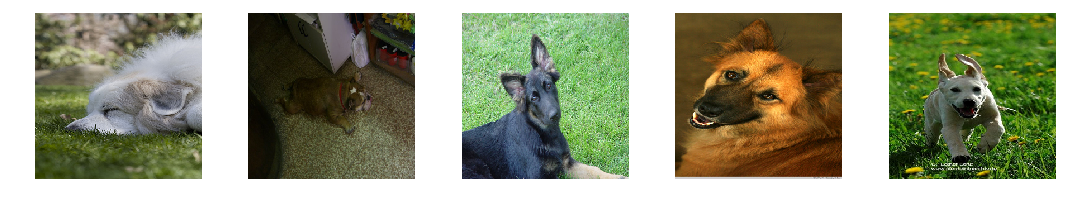

In [13]:
print('Test image:')
print(Y_test[test_idx], rbf_margins_test[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)

print('Top from RBF:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], rbf_margins_train[train_idx], rbf_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
# plt.savefig('figs/fig-rbf-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Dogs:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
counter = 4
for i, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[:-200:-1]):
    if Y_train[train_idx] == -1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
# plt.savefig('figs/fig-inception-dogs.png', dpi=600, bbox_inches='tight')
plt.show()